In [45]:
import os

In [46]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [47]:

os.chdir("../.")

In [48]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [49]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [50]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    train_data_file: Path
    test_data_file: Path
    target_column: str
    

In [51]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [52]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        schema =  self.schema.target_column
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file),
            target_column= schema.name
            )
        
        
        return data_transformation_config
    

In [53]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import  plotly.express as px


     


In [54]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        
        
    def convert_eur_to_usd_and_drop_currency(self):
        
        # Load the data
        data = pd.read_csv(self.config.customer_path)
        
        eur_to_usd_rate = 1.08  # exchange rate
        
        # Convert only EUR rows
        data['amount'] = data.apply(
            lambda row: row['amount'] * eur_to_usd_rate if row['currency'] == 'EUR' else row['amount'],
            axis=1
        )
        
        # Drop the currency column
        data.drop(columns=['currency'], inplace=True)
        
        print("All amounts converted to USD and 'currency' column dropped.")
        
        # save the data in the specified path
        data.to_csv(self.config.transformed_data_file, index=False)
        
        return data

    def transform_data(self):
        
        import datetime
        """
        Transform the data as per the requirements
        """
        
        # Load the data
        data = pd.read_csv(self.config.transformed_data_file)
        
        
        # Performing transformations
        data = data.sort_values(by=['customerid', 'transactiondate'])
        
        # Creating a copy to avoid modifying the original
        data_copy = data.copy()

        # Counting how many times each channel was used by a customer
        channel_counts = data_copy.groupby(['customerid', 'channel']).size().unstack(fill_value=0)

        # Renaming columns to avoid confusion
        channel_counts.columns = [f'channel_count_{col.lower()}' for col in channel_counts.columns]

        # Merging with main dataset
        data = data.merge(channel_counts, on='customerid', how='left')
        
        # Function to get most used channel for each customer
        most_used_channel = data_copy.groupby('customerid')['channel'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
        data['most_used_channel'] = data['customerid'].map(most_used_channel)


        
        # changing transactiondate to datetime format
        data['transactiondate'] = pd.to_datetime(data['transactiondate'])
        
        
        
        # extract year from transactiondate
        data['year'] = data['transactiondate'].dt.year
        
        # extract month and year from transactiondate
        data['month'] = data['transactiondate'].dt.month
        
        # extract day from transactiondate
        data['day'] = data['transactiondate'].dt.day
        
       
        
        
        # extract total fees from creditcardfees, insurancefees and late
        #data['total_fees'] = data['creditcardfees'] + data['insurancefees'] + data['latepaymentamount']
        
     
        # extract binary flags from 'Channel'
        data['is_branch'] = (data['channel'] == 'Branch').astype(int)
        data['is_atm'] = (data['channel'] == 'ATM').astype(int)
        data['is_mobile'] = (data['channel'] == 'Mobile').astype(int)
        data['is_online'] = (data['channel'] == 'Online').astype(int)
      
       
        
        # drop relating columns
        data.drop(columns=['transactiondate',
                           'transactionid',
                           'creditcardfees',
                           'insurancefees',
                           'latepaymentamount',
                           'channel',
                           'customerid',
                           'branchlong',
                           'branchlat',
                
                           'customersegment'],
                           inplace=True)
        
        
        print(":"*100)
        
        data.info()
        print(":"*100)
        
        data.describe()
        print(":"*100)
        print(data.columns)
        print(":"*100)
        
        #drop na
        data.dropna(inplace=True
                            )
        #check null values
        print(data.isnull().sum())
        
        #check the number of  values in the target column
        print(data[self.config.target_column].value_counts())
        
        #resize the dataset to match the number of rows in the target column
        data = data[data[self.config.target_column].notnull()]
        
        # print the first 5 rows of the data
        data.head()
        
        #remove duplicates
        data.drop_duplicates(inplace=True)
    
        #plot "product_name" histogram based of gender using seaborn
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=data, x= self.config.target_column, multiple='stack')
        plt.xticks(rotation=45)

        # Add separated count labels above each segment
        for container in ax.containers:
            # Add offset so overlapping labels are vertically separated
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + height / 2,  # Place label at the middle of the segment
                        f'{int(height)}',
                        ha='center',
                        va='center',
                        fontsize=9,
                        color='white',  # or 'black' depending on your bar color
                        weight='bold'
                    )


        plt.title("Recommended Products Distribution")
        plt.tight_layout()
        plt.show()
                    
       
        
        #plot "age" histogram
        plt.figure(figsize=(12,6))
        plt.hist(data["transactiontype"], bins=10, edgecolor='black', color= "teal", alpha=0.7)
        plt.title("Transaction Type  Distribution")
        plt.xlabel("Transaction Type")
        plt.ylabel("Frequency")
        plt.savefig("transtype.png")
        
    
        
        #plot "branch city" vs "amount" bar plot
        plt.figure(figsize=(10,6))
        plt.bar(data["branchcity"], data["amount"], color="grey")
        plt.title("Branch City vs Amount Plot")
        plt.xlabel("Branch City")
        plt.ylabel("Amount")
        plt.savefig("branchcity_amnt.png")
        
       
        # use plotly 
        import plotly.express as px
        fig = px.bar(data, x="branchcity", y="amount", color="transactiontype", barmode="group")
        fig.show()
        
        #plot "branch city" vs "amount" scatter plot
        import plotly.graph_objects as go
        fig = go.Figure(data=[go.Bar(x=data['branchcity'], y=data['amount'])])          
        fig.update_layout(title="Branch City vs Amount Plot", xaxis_title="Branch City", yaxis_title="Amount")          
        fig.show()    
        
        # drop branch city column
        data.drop(columns=['branchcity'], inplace=True)
        print(":"*100)
        
                                                                  
                                                                  
                                                                  
        # plot a correlation matrix
        correlation_matrix = data.select_dtypes(include= ['float64', 'int64']).corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
        plt.title("Correlation Matrix")
        plt.show()
        plt.savefig('correlation_matrix.png')
    
        # Save the data to a CSV file to the specified path
        os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
        data.to_csv(self.config.transformed_data_file, index=False)
        logger.info(f"Transformed data saved to {self.config.transformed_data_file}")
        print(f"Transformed data saved to {self.config.transformed_data_file}")
        
        
        
        
        
        
        
        return data
      
    def split_data(self):
        data =  pd.read_csv(self.config.transformed_data_file)  
        
        #  splitting data into train and test sets
        train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
        
        # print the first 5 rows of the train and test data
        print("Train Data:")
        print(train_data.head())
        
        print("Test Data:") 
        print(test_data.head())
        
        print("Columns for training dataset:")
        print(train_data.columns)
        
        print("Columns for testing dataset:")
        print(test_data.columns)
        
        #save train_data and test_data to csv files
        os.makedirs(os.path.dirname(self.config.test_data_file), exist_ok=True)
         
        os.makedirs(os.path.dirname(self.config.train_data_file), exist_ok=True)
        train_data.to_csv(self.config.train_data_file, index=False)
        test_data.to_csv(self.config.test_data_file, index=False)
        
        logger.info(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        print(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        # Log the shapes of the train and test sets
        logger.info(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        #print the shapes of the train and test sets
        print(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        # Log the shapes of the train and test sets
        return train_data, test_data    
        
        
      

[2025-06-09 21:02:16,837: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-09 21:02:16,977: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-09 21:02:16,992: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-09 21:02:16,996: INFO: common: created directory at: artifacts]
[2025-06-09 21:02:17,016: INFO: common: created directory at: artifacts]
All amounts converted to USD and 'currency' column dropped.
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transactiontype       20000 non-null  object 
 1   amount                20000 non-null  float64
 2   productcategory       20000 non-null  object 
 3   productsubcategory    20000 non-null  object 
 4   branchcity    

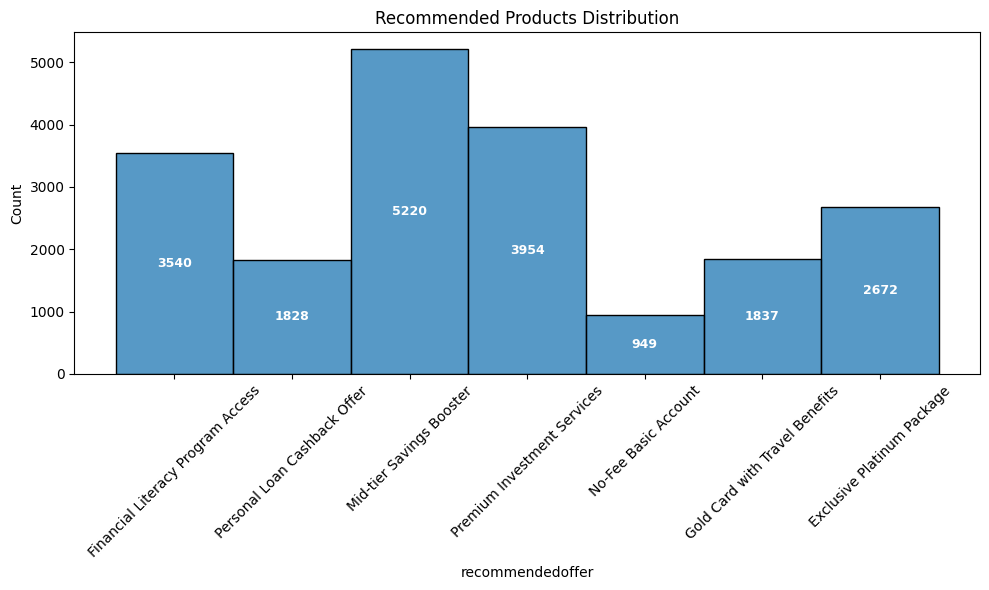

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


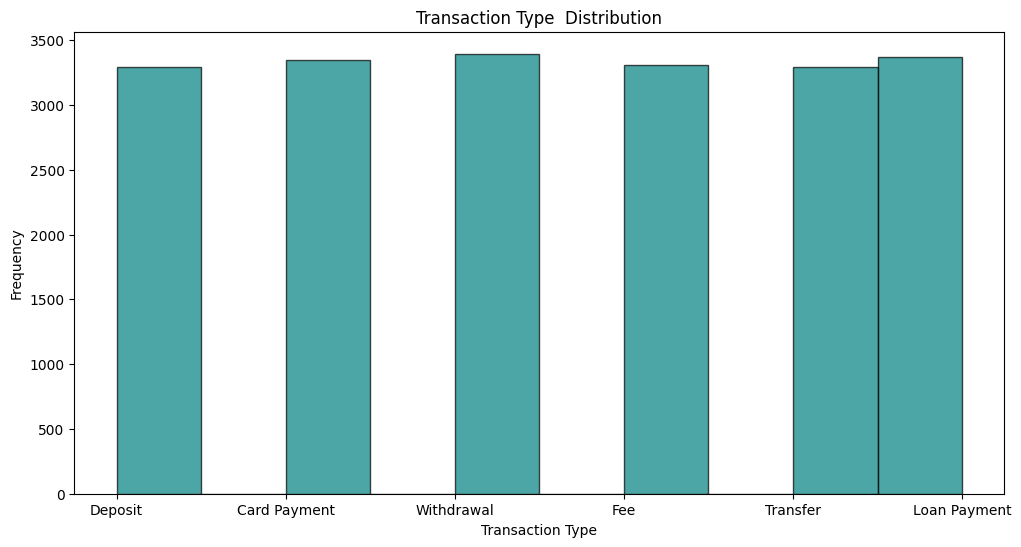

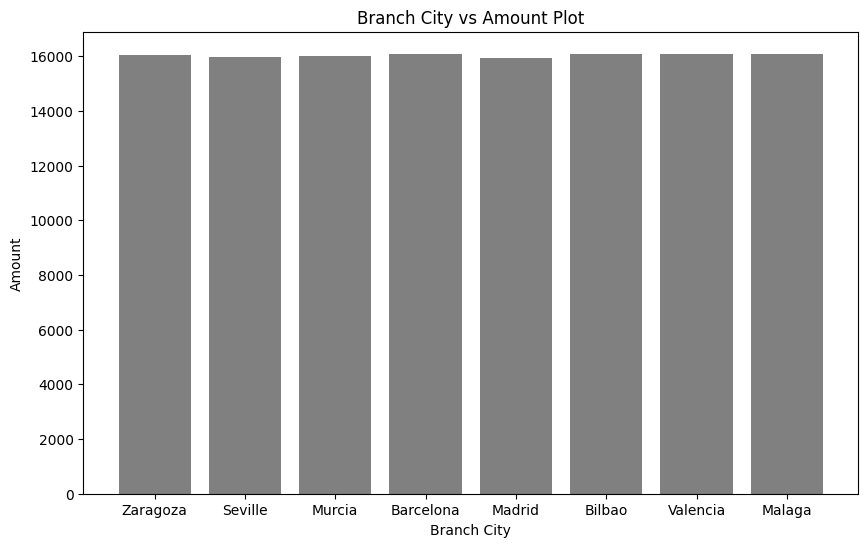

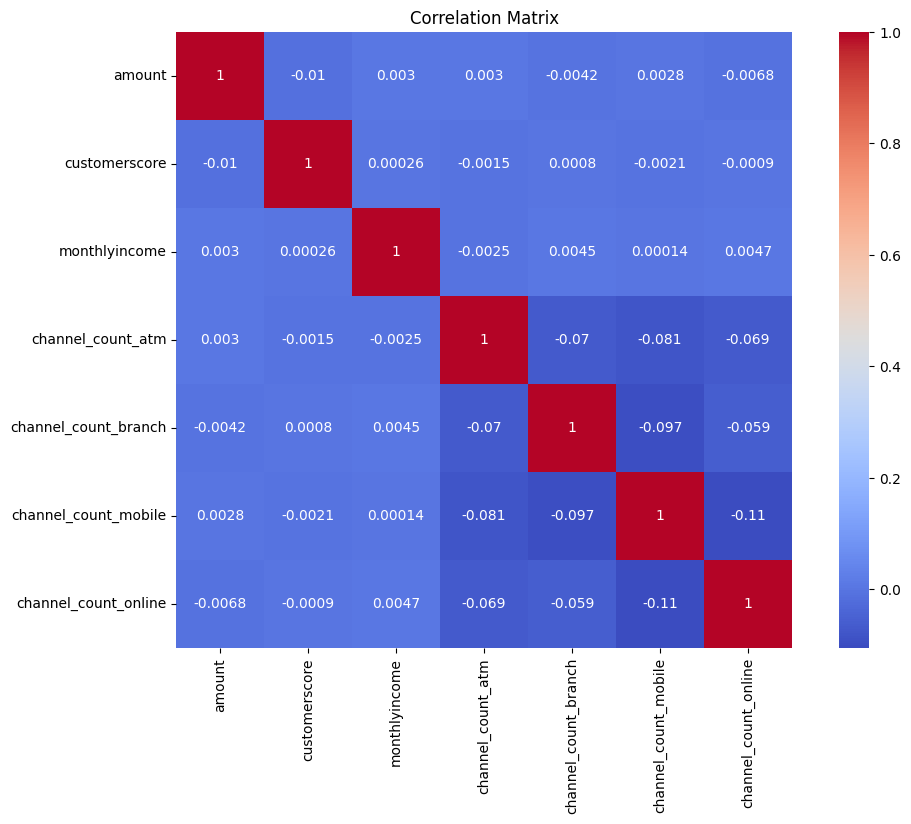

[2025-06-09 21:04:24,653: INFO: 3364113233: Transformed data saved to artifacts\data_ingestion\transform_data.csv]
Transformed data saved to artifacts\data_ingestion\transform_data.csv
Train Data:
      transactiontype        amount  productcategory productsubcategory  \
17218         Deposit  12075.266419         Mortgage            Student   
15188      Withdrawal   7972.298175         Mortgage           Platinum   
11295    Card Payment   3821.334547  Savings Account           Business   
19772      Withdrawal    945.292067  Savings Account           Business   
13072    Card Payment   4226.073017             Loan           Business   

       customerscore  monthlyincome             recommendedoffer  \
17218            575        8980.42   Exclusive Platinum Package   
15188            680        7462.95   Exclusive Platinum Package   
11295            301        6662.14     Mid-tier Savings Booster   
19772            601        2570.82         No-Fee Basic Account   
13072       

<Figure size 640x480 with 0 Axes>

In [55]:

try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    
    
    data_transformation.convert_eur_to_usd_and_drop_currency()
    
    data_transformation.transform_data()
    data_transformation.split_data()
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    